# Analysis

## Setup

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings

The 'ecrest' class has been imported from eCREST_cli.py

An instance of this object will be able to:
- open an neuroglancer viewer for proofrieading (see "Proofread using CREST")
    - add-remove segments (using graph feature for efficiency)
    - format itself and save itself as a CREST-style .json
- convert from neuroglancer json (see "Convert From Neuroglancer to eCREST")
    - format itself and save itself as a CREST-style .json
    


### Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [2]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

In [3]:
dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

## Get all cells info

In [14]:
nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

cell 313068145 is not cell-typed in json


In [259]:
# [k for k,v in cell_type.items() if v == 'glia']

In [ ]:
# # # IF NEED TO CELL TYPE....


# json_path = Path(settings_dict['save_dir'])
# filename = 'cell_graph_644143297__2023-04-18 20.22.35.json'
# filepath = json_path / filename

# crest = ecrest(settings_dict,filepath= filepath)#, launch_viewer=False)


# # Assign the cell type and which method you are using (manual or auto)
# cell_type = 'mg1'
# method = 'manual'

# ## Do not edit
# crest.define_ctype(cell_type,method)

# crest.save_cell_graph(directory_path = filepath.parent, file_name=filepath.name, save_to_cloud=False); 

In [251]:
search_key = 'Gran'
dict(filter(lambda item: search_key in item[1], cell_type.items()))

{}

In [254]:
search_key = 'gran'
dict(filter(lambda item: search_key in item[1], cell_type.items()))
# [val for key, val in cell_type.items() if val in search_key]

{}

## Get all segments

In [15]:

# Create a base_segments dictionary of all reconstructed cells 
'''
when done, can this be saved as a json? maybe quicker to load than to re-go through all cells?
'''

base_segments = {}
for x in nodes:
    # if cell_type[x] in network_types: # if do this, you can't check if the post-syn segments exist as a reconstruction
    cell = ecrest(settings_dict,filepath = nodefiles[x])#,launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']
    try:
        assert cell.cell_data['metadata']['main_seg']['base'] == x
    except:
        print(x,cell.cell_data['metadata']['main_seg']['base'])

## Build Graph

In [16]:
network_types = ['mg1','mg2','lg','lf','sg1','sg2','sgx','grc','aff']

In [17]:
ell = ig_Graph(directed = True) 
ell.add_vertices([n for n in nodes if cell_type[n] in network_types])

# assign cell types to each node
for x in ell.vs:
    x['cell_type'] = cell_type[x['name']]

In [ ]:
# use this code cell to delete some of the vertices (cells)

# to_delete_ids = [v.index for v in ell.vs if v['cell_type'] not in ['mg2','lg','mg1','lf','lx','mgx']]
# ell.delete_vertices(to_delete_ids)

In [18]:
synanno_type = 'post-synaptic'

## find edges and set the cell-structure attribute of the edge based on which part of the cell the edge goes to
edge_list = []
cells_with_synapses = []
cells_without_synapses = []
# for each node,

with tqdm(total=ell.vcount()) as pbar:
    for x_pre in ell.vs:
        pbar.update(1)
    # x_pre = ell.vs.find('128473437')

        # if the node has post-synaptic annotations (the current cell is assumed pre-synaptic)
        pre = ecrest(settings_dict,filepath = nodefiles[x_pre['name']])#,launch_viewer=False)
        if pre.cell_data['end_points'][synanno_type] != []:

            cells_with_synapses.append([x_pre['name'],x_pre['cell_type'],len(pre.cell_data['end_points'][synanno_type])])

            # for each synapse
            for syn_ in pre.cell_data['end_points'][synanno_type]:
                try:
                    post_seg = syn_[3]

                    # go through each other nodes
                    for x_post in ell.vs:
                        post = base_segments[x_post['name']] #ecrest(settings_dict,filepath = nodefiles[x_post['name']],launch_viewer=False)
                    # for x_post in nodes:
                    #     post = base_segments[x_post] #ecrest(settings_dict,filepath = nodefiles[x_post['name']],launch_viewer=False)

                        for k,v in post.items():

                            for v_ in list(v): #find keys (can be multiple on the same cell) for matching segment ids
                                if post_seg == v_: 
                                    # add edge to the graph between current node and matching node
                                    edge_list.append([x_pre['name'],x_post['name'],k])
                                    # edge_list.append([x_pre['name'],x_post,k])

                except IndexError as msg:
                    cellid = x_pre['name']
                    print(msg, f'for cell {cellid} synapse at syn_ has no segment id')

        else:
            cells_without_synapses.append([x_pre['name'],x_pre['cell_type'],len(pre.cell_data['end_points'][synanno_type])])
            cellid = x_pre['name']
            # print(f'no synapses for {cellid}')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 413/413 [06:49<00:00,  1.01it/s]


### Edges

#### Ignore cell structure

If just want different cell pairs to count as unique (ignore morphology), use the following cell

In [19]:
edge_list_cell_pairs = [[r[0],r[1]] for r in edge_list]

edge_scaling = 10
df = pd.DataFrame(edge_list_cell_pairs,columns = ['pre','post'])

df_edges = deepcopy(df.value_counts().reset_index(name='weight'))
# df_edges['weight_norm'] = (df_edges['weight'] / df_edges['weight'].max()) * edge_scaling

for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=ell.vs.find(r['pre'])['cell_type']
    df_edges.loc[i,'post_type']=ell.vs.find(r['post'])['cell_type']

In [247]:
# for each unique edge, get the cell-type pair and structure
for i,r in df_edges.iterrows():
    ell.add_edge(r['pre'],r['post'],weight = r['weight'])#r['weight_norm'])#,structure = r['structure'])

In [260]:
df_edges

,pre,post,weight,pre_type,post_type
0,481412554,142603072,27,grc,aff
1,223881844,60081840,17,grc,aff
2,481412554,223835257,14,grc,aff
3,386392158,306242528,10,mg2,grc
4,128832297,139135155,8,sg1,grc
...,...,...,...,...,...
228,228321391,56569586,1,grc,aff
229,299496636,310855106,1,mg1,grc
230,228366816,139041402,1,grc,aff
231,299496636,303166992,1,mg1,mg2


In [261]:
df_edges[["pre_type","post_type"]].value_counts()

pre_type  post_type
sg1       grc          48
mg1       grc          27
          mg2          26
          sg2          26
mg2       sg1          19
grc       grc          17
mg2       sgx          16
grc       aff          14
sg2       sg1           8
          sgx           8
mg2       grc           5
grc       sg1           4
mg1       sgx           3
mg2       mg1           3
sg2       aff           2
mg2       aff           2
          mg2           1
grc       sgx           1
          mg2           1
sg1       sg2           1
grc       mg1           1
dtype: int64

In [262]:
# print(f'comprising {len(df_edges)} unique edges among:')
print(f'{df_edges[["pre_type","post_type"]].value_counts().reset_index(name="counts")["counts"].sum()} unique edges among:')
print(f'{len(df["pre"].unique())} unique pre synaptic cells - to - {len(df["post"].unique())} unique post-synaptic cells (counts different structures on same cell as same)')

233 unique edges among:
15 unique pre synaptic cells - to - 201 unique post-synaptic cells (counts different structures on same cell as same)


In [ ]:
df_edge_counts = df_edges[['pre_type','post_type']].value_counts().reset_index(name='counts')

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['lf'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['lf'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['lg'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['lg'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['mg2'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['mg1'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

#### Cell Structures included

If want to count different cell structure targets as unique, use the following cell.  

If not, ignore it

In [ ]:
edge_scaling = 10
df = pd.DataFrame(edge_list,columns = ['pre','post','structure'])

df_edges = deepcopy(df.value_counts().reset_index(name='weight'))
df_edges['weight_norm'] = (df_edges['weight'] / df_edges['weight'].max()) * edge_scaling

for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=ell.vs.find(r['pre'])['cell_type']
    df_edges.loc[i,'post_type']=ell.vs.find(r['post'])['cell_type']

In [ ]:
# for each unique edge, get the cell-type pair and structure
for i,r in df_edges.iterrows():
    ell.add_edge(r['pre'],r['post'],weight = r['weight_norm'],structure = r['structure'])

In [ ]:
# print(f'comprising {len(df_edges)} unique edges among:')
print(f'{df_edges[["pre_type","post_type","structure"]].value_counts().reset_index(name="counts")["counts"].sum()} unique edges among:')
print(f'{len(df["pre"].unique())} unique pre synaptic cells - to - {len(df["post"].unique())} unique post-synaptic cells (counts different structures on same cell as different)')

In [ ]:
df_edge_counts = df_edges[['pre_type','post_type','structure']].value_counts().reset_index(name='counts')

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['lf'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['lf'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['lg'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['lg'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['mg2'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['mg1'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

### Check for any synapses on self

In [17]:
vx_sizes = [16, 16, 30]

for i,r in df_edges.iterrows():
    if r['pre']==r['post']:
        print(r['pre'])
        cell = ecrest(settings_dict,filepath = nodefiles[r['pre']])
        for syn_ in cell.cell_data['end_points']['post-synaptic']:
            post_seg = syn_[3]
            for i,s in enumerate(syn_[0:3]):
                syn_[i] = s/vx_sizes[i] 
            if post_seg in [str(a) for b in base_segments[r['pre']].values() for a in b]:
                print(f'delete synapse {syn_}')       
        

In [263]:
print(f'{len(ell.vs)} cells in the network that fall within cell types of interest (nodes in the graph):')
print('')
for ctype in network_types:
    these_cells = ell.vs.select(lambda v: ctype in v['cell_type'])
    print(f'{len(these_cells)} {ctype} cells.')# {len(ell.vs.select(lambda v: 'lg' in v['cell_type']))} lg cells. {len(e
print('')

df_allsyn = pd.DataFrame(cells_with_synapses)
print(f'{len(df_allsyn[df_allsyn[1].isin(["mg1","mg2"])])} of these are mg cells with post-synaptic segments labeled for their synapses')
# print(f'{len(df_edges[df_edges['pre_type'].str.contains("mg")])} of these are mg_ cells with post-synaptic segments labeled for their synapses')

print(f'{df_allsyn[df_allsyn[1].isin(["mg1","mg2"])][2].sum()} total post-synapstic segments labeled from mg_ cells in the network')

# cells_without_synapses

df_nosyn = pd.DataFrame(cells_without_synapses)

# print(f'{len(df_nosyn[df_nosyn[1].str.contains(["mg1","mg2"])])} mg1/2 cells without labeled synapses')
print(f'{len(df_nosyn[df_nosyn[1].isin(["mg1","mg2"])])} mg1/2 cells without labeled synapses')


######
print('')
print(f'{len(df_allsyn[df_allsyn[1].isin(["sg1","sg2","sgx"])])} of these are sg cells with post-synaptic segments labeled for their synapses')
# print(f'{len(df_edges[df_edges['pre_type'].str.contains("mg")])} of these are mg_ cells with post-synaptic segments labeled for their synapses')

print(f'{df_allsyn[df_allsyn[1].isin(["sg1","sg2","sgx"])][2].sum()} total post-synapstic segments labeled from sg_ cells in the network')

# cells_without_synapses

df_nosyn = pd.DataFrame(cells_without_synapses)

# print(f'{len(df_nosyn[df_nosyn[1].str.contains(["mg1","mg2"])])} mg1/2 cells without labeled synapses')
print(f'{len(df_nosyn[df_nosyn[1].isin(["sg1","sg2","sgx"])])} sg_ cells without labeled synapses')

411 cells in the network that fall within cell types of interest (nodes in the graph):

58 mg1 cells.
67 mg2 cells.
34 lg cells.
37 lf cells.
46 sg1 cells.
28 sg2 cells.
33 sgx cells.
93 grc cells.
15 aff cells.

6 of these are mg cells with post-synaptic segments labeled for their synapses
797 total post-synapstic segments labeled from mg_ cells in the network
119 mg1/2 cells without labeled synapses

3 of these are sg cells with post-synaptic segments labeled for their synapses
387 total post-synapstic segments labeled from sg_ cells in the network
104 sg_ cells without labeled synapses


summary of mg

In [210]:
print(f'{len(df)} synapses with reconstructed partners in current network,')
print(f'{len(df_edges)} unique edges total (of various weights)')

print('')

print(f'{df_edges[df_edges["pre_type"].str.contains("mg")]["weight"].sum()} synapses with reconstructed partners from mg cells pre-synaptically.')
print(f'{df_edges[df_edges["pre_type"].str.contains("sg")]["weight"].sum()} synapses with reconstructed partners from sg cells pre-synaptically.')
print(f'{df_edges[df_edges["pre_type"].str.contains("grc")]["weight"].sum()} synapses with reconstructed partners from grc cells pre-synaptically.')

print('')

print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="mg1"]["pre"]))} mg1 cells with ')
print(f'{df_edges[df_edges["pre_type"]=="mg1"]["weight"].sum()} connected synapses with a reconstructed partner in these mg1')

print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="mg2"]["pre"]))} mg2 cells')
print(f'{df_edges[df_edges["pre_type"]=="mg2"]["weight"].sum()} connected synapses with a reconstructed partner in these mg2')

print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="sg1"]["pre"]))} sg1 cells with ')
print(f'{df_edges[df_edges["pre_type"]=="sg1"]["weight"].sum()} connected synapses with a reconstructed partner in these sg1')

print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="sg2"]["pre"]))} sg2 cells')
print(f'{df_edges[df_edges["pre_type"]=="sg2"]["weight"].sum()} connected synapses with a reconstructed partner in these sg2')

print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="sgx"]["pre"]))} sgx cells')
print(f'{df_edges[df_edges["pre_type"]=="sgx"]["weight"].sum()} connected synapses with a reconstructed partner in these sgx')

print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="grc"]["pre"]))} grc cells')
print(f'{df_edges[df_edges["pre_type"]=="grc"]["weight"].sum()} connected synapses with a reconstructed partner in these grc')

# with pd.option_context('display.max_rows', 10):
#     display(df_edges)

4144 synapses with reconstructed partners in current network,
1135 unique edges total (of various weights)

3287 synapses with reconstructed partners from mg cells pre-synaptically.
626 synapses with reconstructed partners from sg cells pre-synaptically.
231 synapses with reconstructed partners from grc cells pre-synaptically.

36 mg1 cells with 
1547 connected synapses with a reconstructed partner in these mg1
41 mg2 cells
1740 connected synapses with a reconstructed partner in these mg2
10 sg1 cells with 
282 connected synapses with a reconstructed partner in these sg1
10 sg2 cells
328 connected synapses with a reconstructed partner in these sg2
1 sgx cells
16 connected synapses with a reconstructed partner in these sgx
10 grc cells
231 connected synapses with a reconstructed partner in these grc


## If need to delete edges to re-do something...

In [ ]:
# # if need to delete all edges...
# ell.delete_edges(range(len(ell.es)))

## querying df_edges

### print out quantifications

In [153]:
with pd.option_context('display.max_rows', 20):
    display(df_edges)

,pre,post,weight,pre_type,post_type
0,481412554,142603072,20,grc,aff
1,223881844,60081840,17,grc,aff
2,481412554,223835257,12,grc,aff
3,386392158,306242528,10,mg2,grc
4,128832297,139135155,8,sg1,grc
...,...,...,...,...,...
183,223881844,302946801,1,grc,sgx
184,223881844,301677416,1,grc,sg1
185,218095913,55442904,1,sg2,aff
186,218095913,45233468,1,sg2,sg1


If have structure in edges, can use next cells...

In [ ]:
mask = df_edges['pre_type'].str.lower().isin(['sg1','mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
hfig,ax = plt.subplots(1,figsize=(10,5))
sns.stripplot(ax = ax, x='structure',y='weight',data = df_edges[mask],hue='pre_type', dodge=True, alpha=0.33,jitter=0.33,s=10)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_ylim(0,15)

In [ ]:
mask = df_edges['pre_type'].str.lower().isin(['mg2','sg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
hfig,ax = plt.subplots(1,figsize=(10,5))
sns.stripplot(ax = ax, x='structure',y='weight',data = df_edges[mask],hue='pre_type', dodge=True, alpha=0.33,jitter=0.33,s=10)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_ylim(0,15)

## Graphs

In [185]:
# df_edges[df_edges['pre_type']=='grc']

In [24]:
for d_ in df_edges[df_edges['pre_type']=='sg2'].groupby(['pre']):
    print(d_)

('218095913',             pre       post  weight pre_type post_type
343   218095913  128770984       4      sg2        lg
485   218095913  300459385       3      sg2       mg1
668   218095913  128813171       2      sg2       mg1
672   218095913  299439953       2      sg2       mg1
675   218095913  300474334       2      sg2        lg
947   218095913  299405462       1      sg2       mg1
948   218095913  299392199       1      sg2       mg1
949   218095913  214613070       1      sg2       sg1
959   218095913  213590737       1      sg2       mg1
1004  218095913  213501262       1      sg2       mg1)
('220275752',            pre       post  weight pre_type post_type
88   220275752  129838223       9      sg2        lg
235  220275752  213501262       6      sg2       mg1
288  220275752  300409458       5      sg2       mg1
398  220275752  300474334       4      sg2        lg
678  220275752  214613070       2      sg2       sg1
893  220275752  214550811       1      sg2       mg1
894  2

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_28853/2940923859.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for d_ in df_edges[df_edges['pre_type']=='sg2'].groupby(['pre']):


In [206]:
# df_map = df_edges.
df_map = df_edges[df_edges['pre_type']=='grc'].groupby(['post_type']).sum(numeric_only=True).reset_index()
display(df_map)

,post_type,weight
0,grc,6
1,lf,17
2,lg,47
3,mg1,25
4,mg2,42
5,sg1,61
6,sg2,8
7,sgx,25


In [25]:
# df_map = df_edges.groupby(['pre_type','post_type']).count().sort_values('pre_type').reset_index()
# df_map

df_map = df_edges.groupby(['pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0)
print('raw weights')
display(df_map)
# display(df_map/df_map.sum(axis=1))
print('totals across row')
display(df_map.sum(axis=1))

raw weights


post_type,grc,lf,lg,mg1,mg2,sg1,sg2,sgx
pre_type,,,,,,,,
grc,3.0,14.0,48.0,28.0,57.0,71.0,16.0,33.0
mg1,0.0,1066.0,0.0,10.0,494.0,0.0,8.0,0.0
mg2,0.0,5.0,1203.0,517.0,9.0,3.0,2.0,1.0
sg1,0.0,123.0,0.0,1.0,152.0,2.0,10.0,2.0
sg2,0.0,0.0,118.0,160.0,0.0,47.0,1.0,2.0
sgx,0.0,20.0,0.0,0.0,35.0,0.0,6.0,12.0


totals across row


pre_type
grc     270.0
mg1    1578.0
mg2    1740.0
sg1     290.0
sg2     328.0
sgx      73.0
dtype: float64

<AxesSubplot:xlabel='lf', ylabel='mg2'>

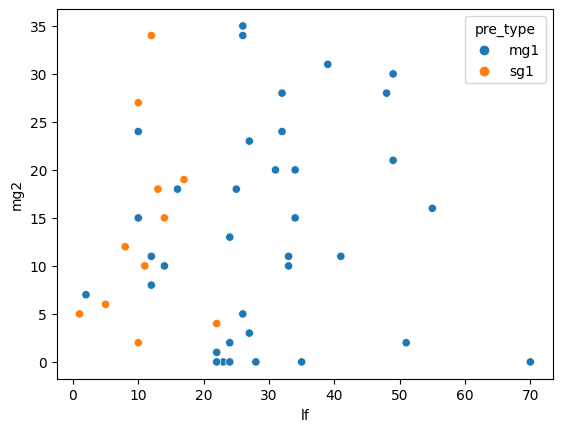

In [71]:
types_ = ['mg1','sg1']
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
# for t in types_:
#     df_grouped = df_edges[df_edges['pre_type']==t].groupby(
#         ['pre','pre_type','post_type']).count().reset_index().pivot(
#         index='pre', columns='post_type', values='post').fillna(0).reset_index()
#     df_grouped['pre_type']=t
#     df_map = pd.concat([df_map,df_grouped])

sns.scatterplot(data=df_map,x='lf',y='mg2',hue='pre_type')

<AxesSubplot:xlabel='lg', ylabel='mg1'>

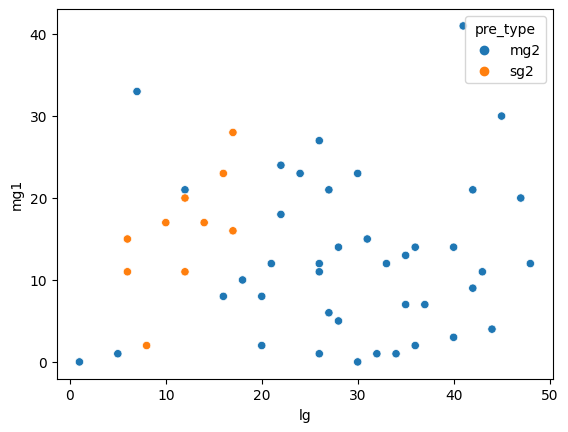

In [70]:
types_ = ['mg2','sg2']
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])

sns.scatterplot(data=df_map,x='lg',y='mg1',hue='pre_type')

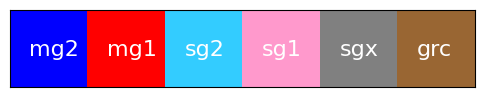

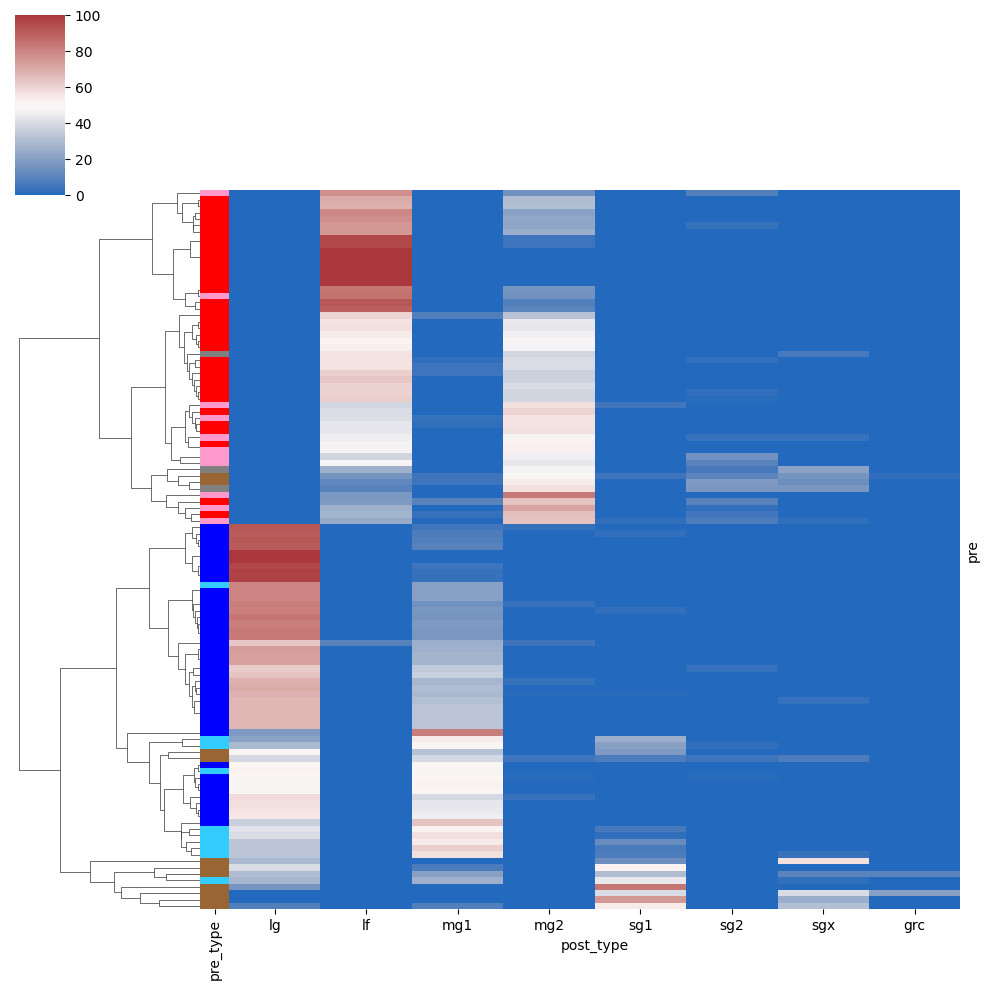

In [288]:
types_ = df_edges['pre_type'].unique()
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    # df_grouped = df_edges[df_edges['pre_type']==t].groupby(
    #     ['pre','pre_type','post_type']).count().reset_index().pivot(
    #     index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
df_map = df_map.fillna(0)

df_map = df_map.set_index('pre')


labels = df_map['pre_type'].unique()
color_pal = sns.color_palette("deep", len(labels))
# color_dict = dict(zip(labels, color_pal))
# sns.palplot(sns.color_palette("deep", len(labels)))

color_dict = {
    'mg2': '#0000ff',
    'mg1': '#ff0000',
    'sg2': '#33ccff',
    'sg1': '#ff99cc',
    'sgx': '#808080',
    'grc': '#996633'    
}
sns.palplot(color_dict.values())
ax = plt.gca()
ax.tick_params(left=False, bottom=False)

for i,v in enumerate(color_dict):
    ax.text(i-0.25, 0.1, v,fontsize=16,color='white') 

data_df = df_map[df_edges['post_type'].unique()].div(df_map[df_edges['post_type'].unique()].sum(axis=1),axis=0).mul(100).round(0)
sns.clustermap(data = data_df,
               method='average',
               col_cluster=False, cmap="vlag", center=50,yticklabels=False,
               row_colors = df_map['pre_type'].map(color_dict));

# data_df = df_map[df_edges['post_type'].unique()]
# cmap = sns.color_palette("blend:#d9d9d9,#000000", as_cmap=True)
# cmap.set_under('white')
# sns.clustermap(data = data_df,
#                method='average',
#                col_cluster=False, cmap=cmap, vmin=1, yticklabels=False,
#                row_colors = df_map['pre_type'].map(color_dict));


# The methods are single, complete, average, weighted, ward, median, centroid
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
# default for seaborn is "average"

post_type,grc,lf,lg,mg1,mg2,sg1,sg2,sgx
pre_type,,,,,,,,
grc,1.0,5.0,18.0,10.0,21.0,26.0,6.0,12.0
mg1,0.0,68.0,0.0,1.0,31.0,0.0,1.0,0.0
mg2,0.0,0.0,69.0,30.0,1.0,0.0,0.0,0.0
sg1,0.0,42.0,0.0,0.0,52.0,1.0,3.0,1.0
sg2,0.0,0.0,36.0,49.0,0.0,14.0,0.0,1.0
sgx,0.0,27.0,0.0,0.0,48.0,0.0,8.0,16.0


Text(50.722222222222214, 0.5, 'pre type')

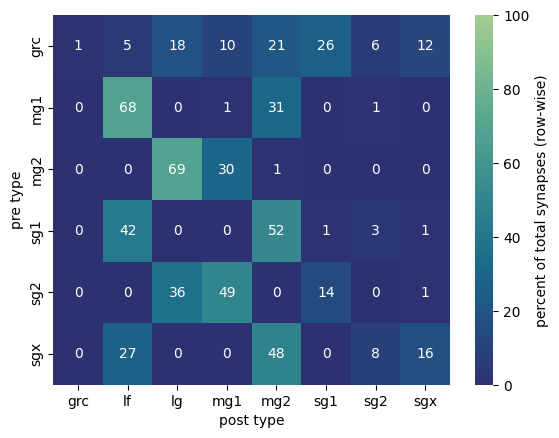

In [239]:
res = df_edges.groupby(['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()

denom = res.groupby('pre_type')['weight'].sum()

res.weight = np.round(res.weight / denom *100)

# res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0)

display(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0))

ax = sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0),
            annot=True,cmap="crest_r",vmin=0,vmax=100,
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

ax.set_xlabel('post type')
ax.set_ylabel('pre type')

In [37]:
palette ={"lg": "#ff0000", "lf": "#0000ff", "mg1": "#fd9400", "mg2": "#9934ff", "sg1":"#ffff00", "sg2":"#ff33cc", "sgx":"#a6a6a6", "grc":"#000000", "aff":"#000000"}
sns.set(font_scale=1.5)

In [ ]:
# colors = ["#fd9400", "#9934ff"] #color_structure = {'mg1':'#fd9400', 'mg2':'#9934ff'}
# # Set your custom color palette
# sns.set_palette(sns.color_palette(colors))

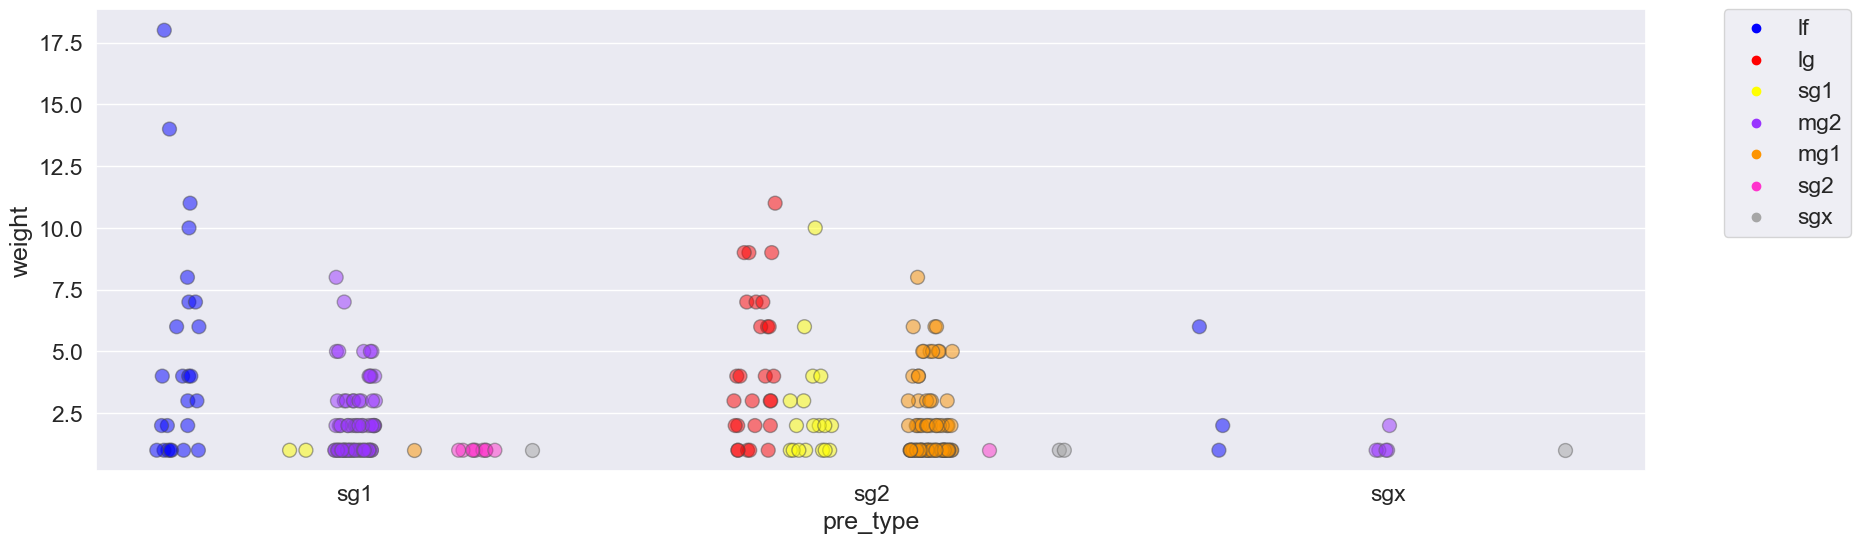

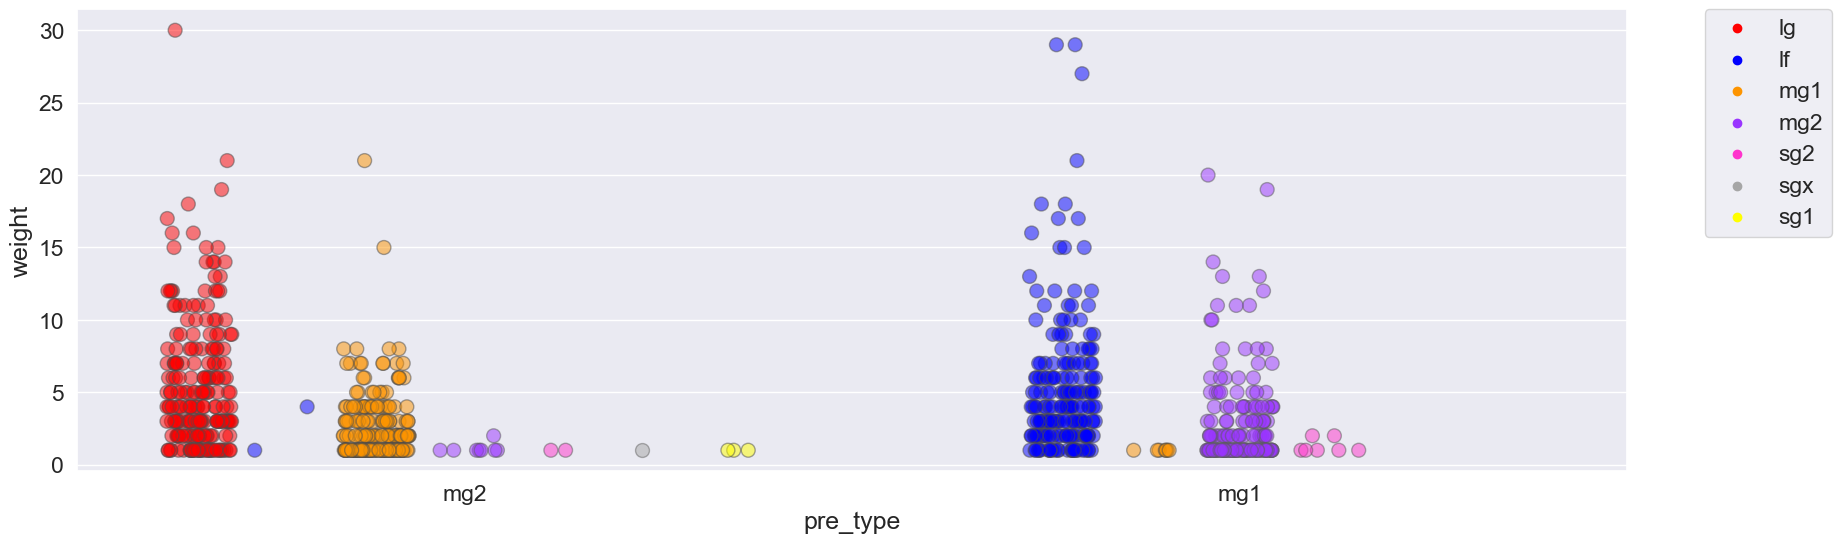

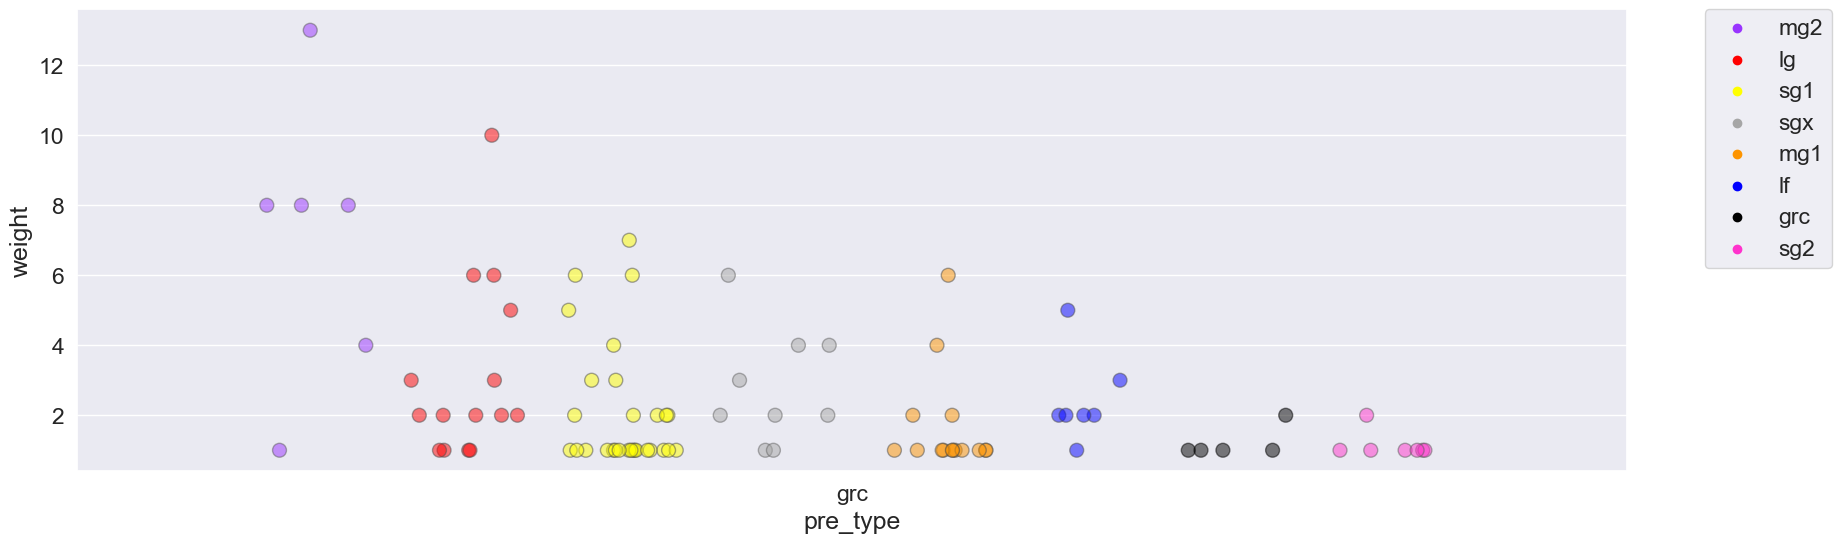

In [211]:
# with sns.set(font_scale=1.5): # df_edges['weight'].hist(bins=20)
plt.figure(figsize=(20,6))
sns.stripplot(df_edges[df_edges["pre_type"].str.contains('sg')],x='pre_type',y='weight',hue='post_type', edgecolors="black",linewidth=1,
              dodge=True, jitter=0.3,alpha = 0.5,s=10,palette=palette)#,split=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# sns.displot(df_edges,x='weight',hue='pre_type',multiple='dodge')

plt.figure(figsize=(20,6))
sns.stripplot(df_edges[df_edges["pre_type"].str.contains('mg')],x='pre_type',y='weight',hue='post_type', edgecolors="black",linewidth=1,
              dodge=True, jitter=0.3,alpha = 0.5,s=10,palette=palette)#,split=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# sns.displot(df_edges,x='weight',hue='pre_type',multiple='dodge')

plt.figure(figsize=(20,6))
sns.stripplot(df_edges[df_edges["pre_type"].str.contains('grc')],x='pre_type',y='weight',hue='post_type', edgecolors="black",linewidth=1,
              dodge=True, jitter=0.3,alpha = 0.5,s=10,palette=palette)#,split=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# sns.displot(df_edges,x='weight',hue='pre_type',multiple='dodge')

In [ ]:
plt.figure(figsize=(10,4))
sns.violinplot(df_edges,x='pre_type',y='weight',scale='count',cut=0,palette=palette);
# plt.figure(figsize=(10,4))
# sns.kdeplot(df_edges,x='weight',hue='pre_type',bw_adjust = 0.5)

In [ ]:
plt.figure(figsize=(15,8))
sns.violinplot(df_edges,x='post_type',y='weight',scale='count',cut=0,palette=palette)
sns.stripplot(df_edges,x='post_type',y='weight',color='black',alpha=0.5,jitter=0.3);
# plt.figure(figsize=(10,4))
# sns.kdeplot(df_edges,x='weight',hue='post_type',bw_adjust = 0.5)

In [ ]:
degree_in = ell.degree(mode="in")
degree_out = ell.degree(mode="out")

df_degree = pd.DataFrame({
    'cell_id': [v['name'] for v in ell.vs],
    'converge': degree_in,
    'diverge': degree_out,
    'type': [cell_type[v['name']] for v in ell.vs]
})

with pd.option_context('display.max_rows', 4):
    display(df_degree)

In [ ]:
# sns.kdeplot(df_degree,x='converge',hue='type', bw_adjust = 0.75)
plt.figure(figsize=(10,6))
sns.violinplot(df_degree[(df_degree.converge != 0)],x='type',y='converge',scale='count',cut=0,palette=palette,order=['lg','lf','mg1','mg2','sg1','sg2','sgx'])
# plt.figure(figsize=(10,4))
sns.swarmplot(df_degree[(df_degree.converge != 0)],x='type',y='converge',color='black',alpha=0.5)#,jitter=0.25)
# sns.stripplot(df_degree,x='type',y='converge',alpha=0.5,jitter=0.25)

plt.figure(figsize=(10,4))
sns.violinplot(df_degree[(df_degree['type'].isin(['mg1','mg2','sg1','sg2','sgx'])) & (df_degree.diverge != 0)],y='diverge',x='type',scale='count',cut=0,palette=palette)
# plt.figure(figsize=(10,4))
sns.swarmplot(df_degree[(df_degree['type'].isin(['mg1','mg2','sg1','sg2','sgx'])) & (df_degree.diverge != 0)],x='type',y='diverge',color='black',alpha=0.5)

In [ ]:
# sns.displot(df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])],x='diverge',hue='type',multiple='dodge')

tmp = df_degree[(df_degree['type'].isin(['mg1','mg2'])) & (df_degree.diverge != 0) & (df_degree.converge != 0)].melt(id_vars=['type'], 
            value_vars=['converge', 'diverge'])

hfig,ax = plt.subplots(figsize=(10,4))
sns.violinplot(tmp,y='value',x='type',hue = 'variable',split=True,scale='count',cut=0,palette={"converge": "#808080", "diverge": "#d0d0d0"},inner=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set(ylim=(0, 40))

In [ ]:
display(df_degree[(df_degree['type'].isin(['mg1','mg2']))])

In [ ]:
display(df_degree[(df_degree['type'].isin(['mg1','mg2']))& (df_degree.diverge != 0) & (df_degree.converge != 0)])

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if 'mg' in b['cell_type']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")


In [ ]:
degree_in = pruned_graph.degree(mode="in")
degree_out = pruned_graph.degree(mode="out")

df_degree = pd.DataFrame({
    'cell_id': [v['name'] for v in pruned_graph.vs],
    'converge': degree_in,
    'diverge': degree_out,
    'type': [cell_type[v['name']] for v in pruned_graph.vs]
})

with pd.option_context('display.max_rows', 4):
    display(df_degree)

In [ ]:
# sns.displot(df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])],x='diverge',hue='type',multiple='dodge')

tmp = df_degree[(df_degree.diverge != 0) & (df_degree.converge != 0)].melt(id_vars=['type'], 
            value_vars=['converge', 'diverge'])

hfig,ax = plt.subplots(figsize=(10,4))
sns.violinplot(tmp,y='value',x='type',hue = 'variable',split=True,scale='count',cut=0,palette={"converge": "#808080", "diverge": "#d0d0d0"},inner=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set(ylim=(0, 40))

In [ ]:
color_dict = {"mg1": "orange", "lf": "red", "mg2": "purple", "lg": "blue"}

# for cell_type in ell.vs["cell_type"]:

for v in ell.vs:
    try:
        v["color"] = color_dict[v['cell_type']]
    except:
        v["color"] = 'black'
# ell.vs["color"] = [try: color_dict[cell_type] except: 'black' for cell_type in ell.vs["cell_type"]]

In [ ]:
color_dict = {"unknown": "brown", "apical dendrite": "red", "basal dendrite": "orange", "axon": "green", "multiple":"gray"}

# for cell_type in ell.vs["cell_type"]:

for e in ell.es:
    try:
        e["color"] = color_dict[e['structure']]
    except:
        e["color"] = 'black'
        # print(e)

In [ ]:
degree_all = ell.degree(mode="in")

# for i,d in enumerate(degree_all):
    # print(ell.vs[i]['cell_type'],d)

# labels = [n['name'] for n in ell.vs]

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all
# visual_style["arrow_size"]=0.1


ig_plot(ell,edge_width = ell.es['weight'],
        vertex_color=ell.vs['color'],
        edge_color = ell.es['color'], 
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if 'mg' in b['cell_type']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'],
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg2','mgx','lg','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg2','mgx','lf','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="in")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg1','mgx','lf','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg1','mgx','lg','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="in")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

## Get all pre-synaptic cells to a specific cellID

In [ ]:
df_edges[df_edges['post']=='393063300'].groupby('pre').sum(numeric_only=True)

## Check for duplicates in mg_network

In [252]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [253]:
crest = ecrest(settings_dict,launch_viewer=False)

base_segments = crest.get_base_segments_dict(dirpath)

In [254]:
df_all = pd.DataFrame()
for k,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    df = cell.check_duplicates(base_segments)
    if not df.empty:
        df_all = pd.concat([df_all,df]) 
        
display(df_all)

,self,dups,overlap-percent,number_seg_lap
309,132543482,303166992,1.000000,2299.0
610,139041402,55442904,0.913043,189.0
455,142464507,395567735,0.094911,69.0
111,143698367,143698547,1.000000,423.0
110,143698547,143698367,1.000000,423.0
212,214627855,221559187,0.966667,58.0
197,220043717,220044275,0.907540,1649.0
196,220044275,220043717,0.943364,1649.0
217,220399756,222673388,0.545455,30.0
136,221559187,214627855,0.044513,58.0


# create crest files for post-syn segments not in cells

In [336]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

# Create a base_segments dictionary of all cells

base_segments = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']

In [337]:
pre_type = 'grc'

# todo_dict= {}
# post_segs_without_cell = 0
# post_segs_with_cell = 0
df_ = {}

all_syn = set()
for x_pre in nodes:
    pre = ecrest(settings_dict,filepath = nodefiles[x_pre],launch_viewer=False)

    # report if the cell is not cell-typed
    if (pre.get_ctype('manual') == []) | (pre.get_ctype('manual') == ''):
        print(f'cell {x_pre} is not cell-typed in json')
    
    # check if the cell is a cell of type pre_type and if it has post-synaptic segments labeled
    if (pre_type in pre.get_ctype('manual')) & (pre.cell_data['end_points']['post-synaptic'] != []):

        try:
        # for each synapse
            syn_to_find = set([syn_[3] for syn_ in pre.cell_data['end_points']['post-synaptic']])
            for x_post in nodes:
                post_segs = set([a for b in base_segments[x_post].values() for a in b])    
                syn_to_find = syn_to_find.difference(post_segs)

            all_syn = all_syn.union(syn_to_find)
        
        except IndexError as msg:
                # cellid = x_pre['name']
                print(msg, f'for cell {pre.cell_data["metadata"]["main_seg"]["base"]} -- at least one synapse has no segment id')
                
    if (pre_type in pre.get_ctype('manual')) & (pre.cell_data['end_points']['post-synaptic'] == []):
        # print(f'{pre.cell_data["metadata"]["main_seg"]["base"]} is a {pre.get_ctype("manual")} cell and does not have synapses labelled')
        df_[pre.cell_data["metadata"]["main_seg"]["base"]] = pre.get_ctype("manual")
        

In [338]:
# pd.DataFrame.from_dict(df_,orient='index',columns=['type']).reset_index(names='cell')

In [339]:
len(all_syn)

234

In [340]:
base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir']) / 'todo_postsynaptic_mg')

In [341]:
topop=set()
for k,v in base_segments.items():
    if all_syn & v != set():
        # print(f'use reconstruction {k}')
        topop = topop.union(all_syn & v)
    

In [342]:
len(topop)

10

In [343]:
all_syn = all_syn.difference(topop)

In [344]:
len(all_syn)

224

In [345]:
base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir']) / 'todo_postsynaptic_sg')

In [346]:
topop=set()
for k,v in base_segments.items():
    if all_syn & v != set():
        # print(f'use reconstruction {k}')
        topop = topop.union(all_syn & v)
    

In [347]:
len(topop)

8

In [348]:
all_syn = all_syn.difference(topop)

In [349]:
len(all_syn)

216

In [ ]:
todo_dict = {}
for post_seg in list(all_syn):
    post = ecrest(settings_dict,segment_id = post_seg,launch_viewer=False)
    todo_dict[post_seg] = set(post.cell_data['base_segments']['unknown'])
    # post_segs_without_cell+=1
    

In [351]:
len(todo_dict)

216

In [352]:
topop=[]

todo_inds = list(todo_dict.keys())
for k,k_ in itertools.combinations(todo_inds,2):
    if todo_dict[k]&todo_dict[k_]!=set():
        # then they share segments
        topop.append(k_)
topop = np.unique(topop)

In [353]:
len(topop)

50

In [354]:
for segid in topop:
    todo_dict.pop(segid)
    

In [ ]:
for segment_id in sorted(list(todo_dict.keys())):

    cell = ecrest(settings_dict,segment_id = segment_id, launch_viewer=False)
    cell.save_cell_graph(directory_path = Path(settings_dict['save_dir']) / 'todo_postsynaptic_grc')
    



# Find & Delete GLIA "post-synaptic" segments from jsons



In [ ]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [ ]:
glia_seg = ['479108445']

In [ ]:
anno_to_remove = {}

vx_sizes = [16, 16, 30]
# for each node,
for n in nodes:

    # if the node has post-synaptic annotations (the current cell is assumed pre-synaptic)
    pre = ecrest(settings_dict,filepath = nodefiles[n],launch_viewer=False)
    if pre.cell_data['end_points']['post-synaptic'] != []:
        
        for syn_ in pre.cell_data['end_points']['post-synaptic']:
            try: 
                if syn_[3] in glia_seg:
                    anno_to_remove[nodefiles[n]] = syn_


            except IndexError as msg:
                # cellid = x_pre['name']
                print(msg, f'for cell {pre.cell_data["metadata"]["main_seg"]["base"]} -- at least one synapse has no segment id')

In [ ]:
anno_to_remove

In [ ]:
f = '/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/todo_post-synaptic/glia/cell_graph_43621743__2023-04-20 08.33.58.json'
pre = ecrest(settings_dict,filepath = f,launch_viewer=True)

In [ ]:
# filepath = json_path / filename
for f,anno in anno_to_remove.items():
    pre = ecrest(settings_dict,filepath = f,launch_viewer=False)
    updated_anno = [i for i in pre.cell_data['end_points']['post-synaptic'] if i[3] not in [anno[3]]]
    pre.cell_data['end_points']['post-synaptic'] = updated_anno
    
    # print(f.name)
    pre.save_cell_graph(directory_path = f.parent, file_name=f.name, save_to_cloud=False); 
    # print(len(pre.cell_data['end_points']['post-synaptic']),len(updated_anno))

# GET most recent files (by filename date) in folder

In [246]:
# dirname = 'C:/Users/mpetkova/Dropbox/U19_zebrafish/EMfullres/LateralLineCurlDetector/CREST/right_afferents/'
# # os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/EngertLab/Dropbox/CREST/mariela_fish_credentials.json'

# names = os.listdir(dirname);
# cellid_filename=list();
# for ind in range(len(names)):
#     content = names[ind].split('_')
#     if ('cell' in content):
#         cellid_filename.append(names[ind])
dirpath = Path('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network')#/todo_pre-synaptic/sg2')#/todo_pre-synaptic/basal-dendrite')

cellid_filename = [child.name for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

d={}
for name in cellid_filename:
    ID,content_type,date=name.split('_')[2], name.split('_')[0], name.split('_')[-1]
    date=date[:-5]
    #create entry in dict which holds ID, file type (ex: cell_graph) and file path
    if ID not in d:
        d[ID]=[date, name]
        #if there are multiple files with the same ID, keep the info for the newest one
    else:
        if date>d[ID][0]:
            d[ID][0]=date
            d[ID][1]=name
            print(f'newer file exists for {ID}')
            
# ############################################################################################################################ 
# # Collect all the base segments for each ID
# import json

# base_segs = {}

# for key in d.keys():
#     f = open(dirname+d[key][1])
#     data = json.load(f)
#     base_segs[key]=sum(data['base_segments'].values(),[])
#     f.close()

# ############################################################################################################################ 


# Pre-synaptic reconstruction from synapses

In [ ]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)


In [4]:
json_path = Path(settings_dict['save_dir']) #/ 'todo_post-synaptic' #/ 'check-duplicates' #'CC unsure'
filename = 'cell_graph_389812730__2023-07-04 15.33.26.json'

crest = ecrest(settings_dict,filepath= json_path / filename, launch_viewer=False)


In [5]:
vx_sizes = [16, 16, 30]

syn_to_find = set([syn_[3] for syn_ in crest.cell_data['end_points']['pre-synaptic'] if int(syn_[1]/vx_sizes[1])])

In [6]:
len(syn_to_find)

64

In [7]:
# [np.asarray(syn_[0:2])/16 for syn_ in crest.cell_data['end_points']['pre-synaptic'] if syn_[3] in ['394395122']]

First, find if any of these post-synaptic segments are already part of reconstructions completed

In [8]:
base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir']) / 'todo_presynaptic')

In [9]:
topop=set()
for k,v in base_segments.items():
    if syn_to_find & v != set():
        print(f'use reconstruction {k}')
        topop = topop.union(syn_to_find & v)
    

In [10]:
syn_to_find = syn_to_find.difference(topop)

In [11]:
len(syn_to_find)

64

create crest files for each of the unidentified post-synaptic partners

In [12]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)


Save reconstructed_segs as a json to go through manually

In [ ]:
for segment_id in sorted(list(syn_to_find)):

    cell = ecrest(settings_dict,segment_id = segment_id, launch_viewer=False)
    cell.save_cell_graph(directory_path = Path(settings_dict['save_dir']) / 'todo_presynaptic/Krista/grc_386392158')

# Other

## Fix cell_data dictionary keys


In [ ]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_228366816__2023-06-14 09.56.22.json"

In [ ]:
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [ ]:
old_points = cell.cell_data['end_points']
old_points

In [ ]:
end_points = {}
for p in cell.point_types:
    # if p not in cell.cell_data['end_points']:
    end_points[p] = []
        
cell.cell_data['end_points'] = end_points

In [ ]:
cell.cell_data['end_points']['natural end'] = old_points['natural']

In [ ]:
# cell.cell_data['end_points'].pop('natural')
cell.cell_data['end_points'].keys()

In [ ]:
cell.save_cell_graph(directory_path = filepath.parent, file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp

## Figure out what is wrong with a crest file

In [ ]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_213605530__2023-03-29 22.49.21.json"
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [ ]:
cell.cell_data['end_points']['post-synaptic']

## Fix pre-synaptic to be post-synaptic annotation list in converted crest jsons

In [ ]:
json_fix = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Complete/synapses/to-crest/conversion_specs_synapse_fix.json")

with open(json_fix,'r') as f:
    cells_to_fix = f.read()
    cells_to_fix = json.loads(cells_to_fix)

In [ ]:
cells_to_fix = cells_to_fix['cell_info']

In [ ]:
for k,v in cells_to_fix.items():
    try:
        filepath = nodefiles[k]
        cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)
        cell.cell_data['end_points']['post-synaptic'] = deepcopy(cell.cell_data['end_points']['pre-synaptic'])

        cell.cell_data['end_points']['pre-synaptic'] = []
        # cell.save_cell_graph(directory_path = filepath.parent / 'original', file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp
    except KeyError as msg:
        print(msg)
        continue
        

## Anatomical Clustering